<h4>Part I: Research Question</h4>
<p>Can we train the time-series model using the history of revenues to forecast and predict future revenues?<p>
<p>This Data analytics study aims to prepare the history of revenues data and train the time-series model to predict and forecast future revenue.


<h4>Part II: Method Justification</h4>
<p><b>Assumptions:</b>
Data stationarity is the common assumption in time series, a stationary process has the property that the mean, variance, and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose, we mean a flat-looking series, without trend, constant variance over time, a constant autocorrelation structure over time, and no periodic fluctuations.  (NIST 2021)
<p>Autocorrelation is the coefficient of correlation between two values in the time series. (PSU 2021)


<h4>Part III: Data Preparation</h4>
<p><b>The data preparation process</b>

In [636]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

In [637]:
# load the data set.
df = pd.read_csv(r"teleco_time_series .csv", index_col='Day')

df.index=pd.to_datetime(df.index, unit = 'D', origin = '2020-01-01')

df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)

# remove nulls
df=df.dropna()

# check if duplication
df.duplicated().any()

df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


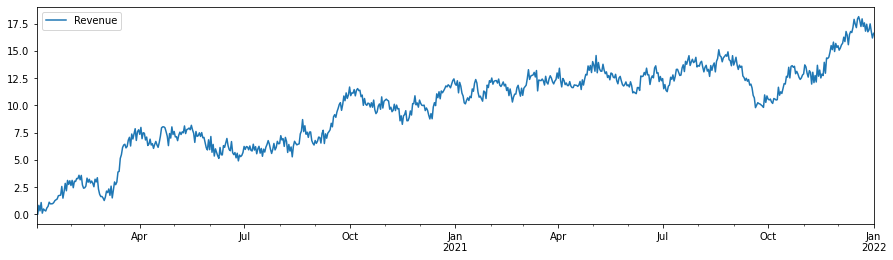

In [638]:
# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
df.plot(figsize=(15, 4), ax=ax1)
plt.show()

In [639]:
df.info

<bound method DataFrame.info of               Revenue
2020-01-02   0.000000
2020-01-03   0.000793
2020-01-04   0.825542
2020-01-05   0.320332
2020-01-06   1.082554
...               ...
2021-12-28  16.931559
2021-12-29  17.490666
2021-12-30  16.803638
2021-12-31  16.194813
2022-01-01  16.620798

[731 rows x 1 columns]>

<h4>The Time Step Format:</h4>
<p>2 columns and 731 rows (days), no Gaps between the data and the frequency are perfect.

In [640]:
# Evaluatinting the Stationarity Run the ADF test on the time series
result = adfuller(df['Revenue'])
# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values', result[4])

ADF Statistic: -1.9246121573101849
p-value: 0.3205728150793957
critical values {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [641]:
# Making the time series stationary
df_stationary = df.diff().dropna()

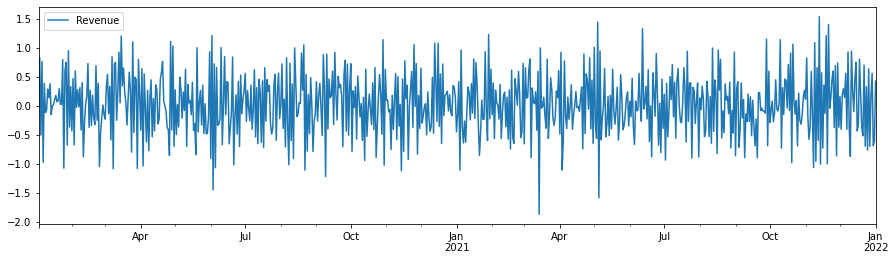

In [642]:
# Show after Making the time series stationary
fig, ax1 = plt.subplots()
df_stationary.plot(figsize=(15, 4), ax=ax1)
plt.show()

In [643]:
# Evaluatinting the Stationarity again 
result = adfuller(df_stationary['Revenue'])
# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values', result[4])

ADF Statistic: -44.87452719387599
p-value: 0.0
critical values {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [644]:
# Save copy of Cleaned dataset
df_stationary.to_csv('prepared_clean_dataset.csv')

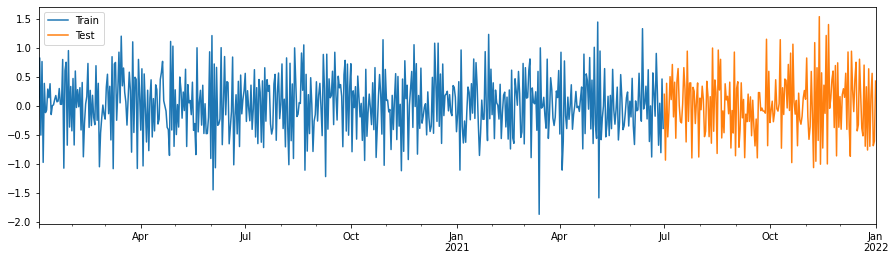

In [645]:
# Split the data into a train and test set
df_train = df_stationary.loc[:'6-30-2021']
df_test = df_stationary.loc['7-1-2021':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
df_train.plot(label = 'Train', figsize=(15, 4), ax=ax)
df_test.plot(label = 'Test', figsize=(15, 4), ax=ax)
ax.legend(labels=['Train', 'Test'])
plt.show()

<h4>Part IV:  Model Identification and Analysis</h4>

<b>Analyze the time series dataset:</b>

50 days:  0.822500880288965


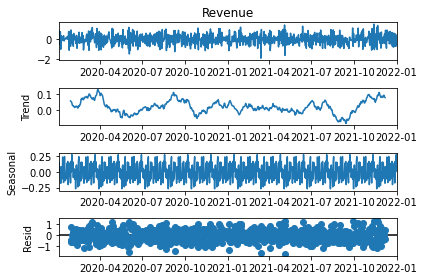

In [646]:
# Run autocorrelation coefficient with 50 days lag
autocorrelation_50 = df['Revenue'].autocorr(lag=50)
print("50 days: ", autocorrelation_50)
decompose=seasonal_decompose(df_stationary['Revenue'], period=50)
decompose.plot()
plt.show()

<AxesSubplot:>

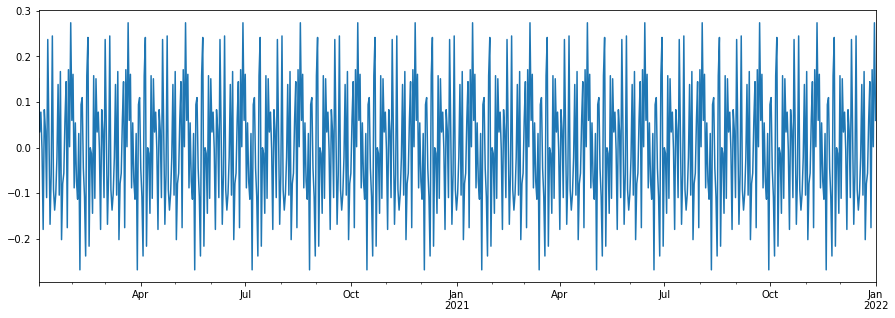

In [647]:
# Seasonal Plot
decompose.seasonal.plot(figsize=(15, 5))

<AxesSubplot:>

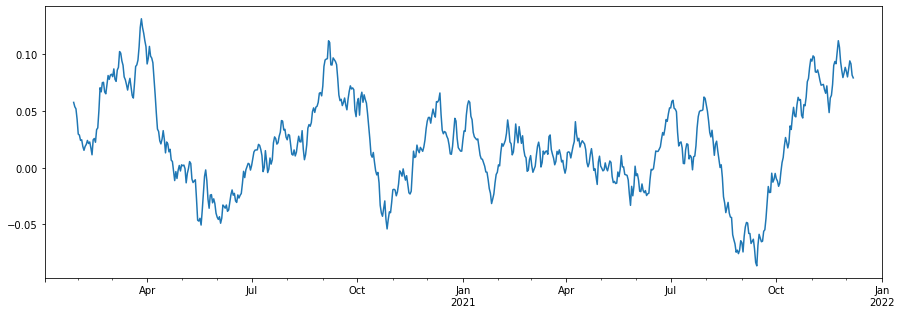

In [648]:
# Trend Plot
decompose.trend.plot(figsize=(15, 5))

<AxesSubplot:>

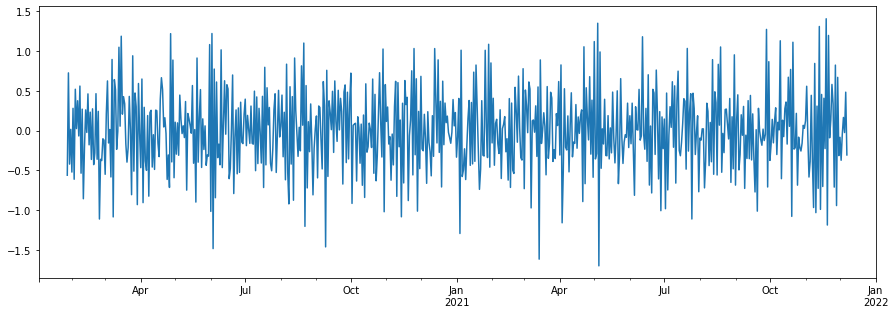

In [649]:
# Seasonal Plot
decompose.resid.plot(figsize=(15, 5))

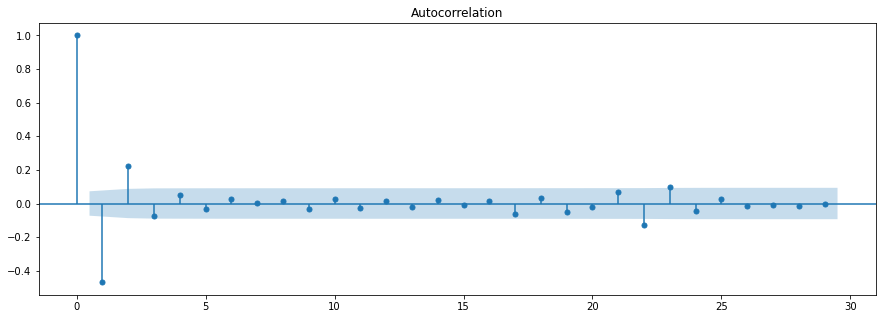

In [650]:
# Autocorrelation Plot
fig, ax1 = plt.subplots()
fig = plot_acf(df_stationary['Revenue'],   ax=ax1)
fig.set_size_inches(15, 5)
plt.show(fig)

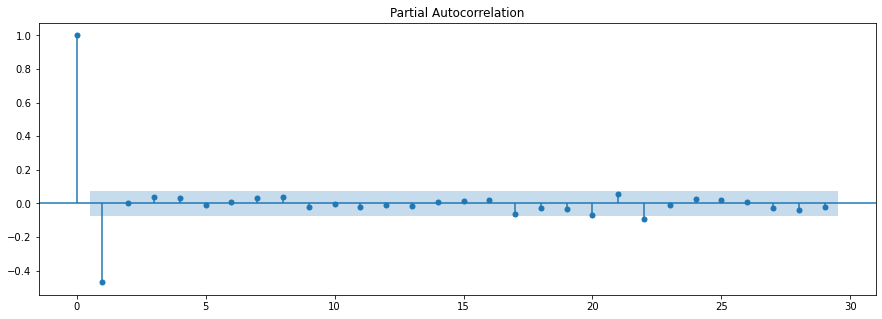

In [651]:
# Partial Autocorrelation Plot
fig, ax1 = plt.subplots()
fig = plot_pacf(df_stationary['Revenue'],  ax=ax1)
fig.set_size_inches(15, 5)
plt.show(fig)

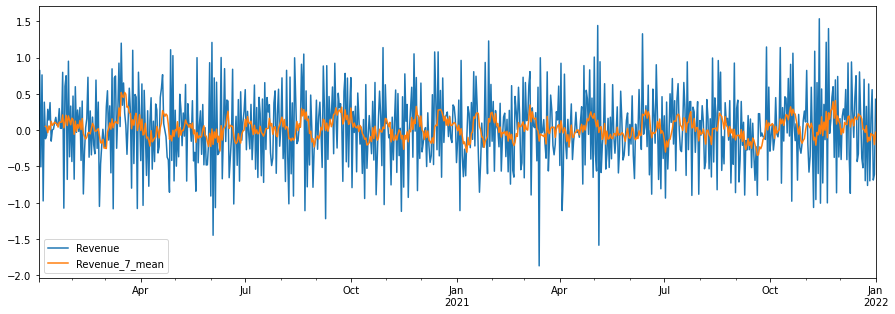

In [652]:
df_sd= df_stationary.copy()
df_sd['Revenue_7_mean']= df_sd['Revenue'].rolling(window=7).mean()
df_sd.plot(figsize=(15, 5))
plt.show()

<b>Spectral Density</b>
<p>the Spectral density represents the frequency domain of a time series. 
Which could view as a group of line waves.(line changes) 

In [533]:
# Fit auto_arima to dataset (best model AR and MA)
auto_arima_fit = auto_arima(df_stationary['Revenue'], start_P=1,
                           start_q=1,
                           max_p=5,
                           max_q=5,
                           m=50,
                           seasonal=True,
                           d=None,
                           D=1,
                           trace=True,
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

auto_arima_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[50] intercept   : AIC=inf, Time=36.17 sec
 ARIMA(0,0,0)(0,1,0)[50] intercept   : AIC=1531.494, Time=1.08 sec
 ARIMA(1,0,0)(1,1,0)[50] intercept   : AIC=1191.636, Time=5.43 sec
 ARIMA(0,0,1)(0,1,1)[50] intercept   : AIC=inf, Time=9.09 sec
 ARIMA(0,0,0)(0,1,0)[50]             : AIC=1529.504, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[50] intercept   : AIC=1357.220, Time=1.13 sec
 ARIMA(1,0,0)(2,1,0)[50] intercept   : AIC=inf, Time=16.31 sec
 ARIMA(1,0,0)(1,1,1)[50] intercept   : AIC=inf, Time=13.51 sec
 ARIMA(1,0,0)(0,1,1)[50] intercept   : AIC=inf, Time=10.50 sec
 ARIMA(1,0,0)(2,1,1)[50] intercept   : AIC=inf, Time=33.60 sec
 ARIMA(0,0,0)(1,1,0)[50] intercept   : AIC=1360.294, Time=3.93 sec
 ARIMA(2,0,0)(1,1,0)[50] intercept   : AIC=1192.922, Time=6.72 sec
 ARIMA(1,0,1)(1,1,0)[50] intercept   : AIC=1192.984, Time=6.35 sec
 ARIMA(0,0,1)(1,1,0)[50] intercept   : AIC=1217.240, Time=5.61 sec
 ARIMA(2,0,1)(1,1,0)[50] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 50)   Log Likelihood                -591.820
Date:                            Sat, 08 Jan 2022   AIC                           1189.640
Time:                                    23:51:03   BIC                           1203.207
Sample:                                         0   HQIC                          1194.892
                                            - 730                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4714      0.035    -13.647      0.000      -0.539      -0.404
ar.S.L50      -0.4813      0.034    -14.243      0.000      -0.548      -0.415
sigma2         0.3273      0.018     18.291      0.000       0.292       0.362
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.68   Prob(JB):                         0.22
Heteroskedasticity (H):               1.13   Skew:                             0.16
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [653]:
# Build SARIMAX model (Final model)
model = sm.tsa.SARIMAX(df_train, 
                      order=(1, 0, 0),
                      seasonal_order=(1, 1, 0, 50),trend='c',
                      freq=df_train.index.freq)

SARIMAX_results = model.fit()

# Print results tables
print(SARIMAX_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  545
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 50)   Log Likelihood                -425.486
Date:                            Mon, 10 Jan 2022   AIC                            858.971
Time:                                    19:54:12   BIC                            875.790
Sample:                                01-03-2020   HQIC                           865.574
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0163      0.026     -0.621      0.535      -0.068       0.035
ar.L1         -0.4777      0.039   

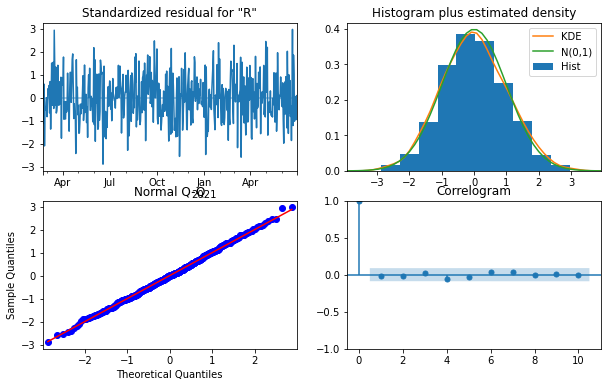

In [654]:
# Plot common diagnostics
SARIMAX_results.plot_diagnostics(figsize=(10, 6))
plt.show()

In [655]:
# Create SARIMA mean forecast
sarima_forecast = SARIMAX_results.get_forecast()
sarima_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int(alpha=0.05)
sarima_se = sarima_forecast.se_mean

In [656]:
print('95%% Confidence Interval between %.2f and %.2f'% (sarima_conf_int['lower Revenue'], sarima_conf_int['upper Revenue']))
print('Mean: %.2f' % sarima_mean)
print('Standard Error: %.2f' % sarima_se)


95% Confidence Interval between -1.43 and 0.77
Mean: -0.33
Standard Error: 0.56


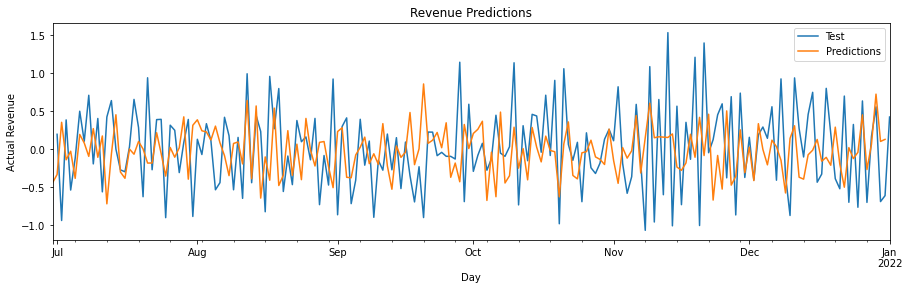

In [657]:
# Predict with respect to test set and visualization

start = '6-30-2021'
end = '12-31-2021'

predictions = SARIMAX_results.predict(start, end, type = 'levels').rename('Predictions')
fig, ax = plt.subplots()
df_test.plot(label = 'Test', figsize=(15, 4), ax=ax)
predictions.plot(label = 'Predictions', figsize=(15, 4), ax=ax)
plt.title('Revenue Predictions')
plt.xlabel('Day')
plt.ylabel('Actual Revenue')
plt.legend(loc='upper left', fontsize = 8)
ax.legend(labels=['Test', 'Predictions'])
plt.show()
# Create an axis


In [659]:
# model Evaluation

# Mean Squared Error
MSE = mean_squared_error(df_test['Revenue'], predictions)
print('MSE: ', round(MSE, 4))
# Root Mean Squared Error
RMSE = rmse(df_test['Revenue'], predictions)
print('RMSE: ', round(RMSE, 4))

MSE:  0.3777
RMSE:  0.6146


<h4>Part V:  Data Summary and Implications</h4>

<b>Summarize your findings and assumptions:</b>

<p>The Data Analysis study used the auto_arima to generate the optimal p, d, and q values; the auto_arima model selected the values (1,0,0) (1,1,0,50) as the optimal values based on the lowest AIC (Akaike Information Criterion) 1189.640.
<p>Using the standard 95% confidence interval, the study results were only a %5 likelihood that the real observation will fail outside the range  -1.43 and 0.77.
<p>The study spitted most of the dataset about 18 months as training data and just the last 6 months as test data and using the test data to compare the results with the forecasting data to give the decision-makers the chance to compare and plan for the forecasting, more data and more analysis will improve the forecasting results.
<p>SARIMA Model evaluation for each predicted and actual displays Mean square error (MSE) 0.37 and Root Mean square error (RMSE) 0.61, which reflects high confidence in the model accuracy.
<p><b>Recommended a course of action:</b> the decision-makers could use the study to define patterns of revenue forecasting, and the data analyst could run more tests on more data to improve the model results.

<b>Acknowledge Sources:</b>
<p>Statistics Solutions. (2021, Dec. 21) Time Series Analysis. [Web Site].  Retrieved from <a href="https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/time-series-analysis/">https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/time-series-analysis/</a>

<p>NIST. (2021, Dec. 21) Time Series Analysis. [Web Site].  Retrieved from
<a href="https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm">https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm</a>

<p>PSU. (2021, Dec. 21) Autocorrelation and Time Series. [Web Site].  Retrieved from
<a href="https://online.stat.psu.edu/stat462/node/188/">https://online.stat.psu.edu/stat462/node/188/</a>


<b>Web Sources:</b>
<p>Kaggle. (2022, Jan. 9) Notebook, Time series analysis. [Web Site].  Retrieved from <a href="https://www.kaggle.com/urayukitaka/notebook-time-series-analysis">https://www.kaggle.com/urayukitaka/notebook-time-series-analysis</a>